In [1]:
from importlib import reload
reload(plt)
%matplotlib notebook

NameError: name 'plt' is not defined

Se cargan los datos desde keras, se normalizan las imagenes de modo que los pixeles queden descritos en el range [0,1], luegos se transforman en vectores unidimensionales y se parten en conjuntos disjuntos de entrenamiento, validación y prueba

In [2]:
from keras.datasets import mnist
import os
import time
import numpy as np
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Se extraen datos para hacer el set de validación
# print(x_train.shape)
# print(x_test.shape)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=(1/6))
#como vector
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('datos de entrenamiento : '+str(x_train.shape)+' '+str(y_train.shape))
print('datos de validacion : '+str(x_val.shape)+' '+str(y_val.shape))
print('datos de pruebas : '+str(x_test.shape)+' '+str(y_test.shape))

Using TensorFlow backend.
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


datos de entrenamiento : (50000, 28, 28) (50000,)
datos de validacion : (10000, 28, 28) (10000,)
datos de pruebas : (10000, 28, 28) (10000,)


Luego se pasa a usar los datos para una red de autoencoder feed forward, en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 × 28 pasa a ser un vector de 784 componentes.

In [3]:
X_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
X_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
X_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print('datos de entrenamiento : '+str(X_train.shape)+' '+str(Y_train.shape))
print('datos de validacion : '+str(X_val.shape)+' '+str(Y_val.shape))
print('datos de pruebas : '+str(X_test.shape)+' '+str(Y_test.shape))

datos de entrenamiento : (50000, 784) (50000, 10)
datos de validacion : (10000, 784) (10000, 10)
datos de pruebas : (10000, 784) (10000, 10)


#### Sección a) Se entrena un AE (1 hddn layer) para generar una representación de MNIST de d' = 2 ,8 ,32 ,64 . Se elije la función de perdida categorical_crossentropy   y el criterio del entrenamiento sigmoid . Determine el porcentaje de compresión obtneido y el error de reconstrucción en cada caso. Se mojra el resulta si elegiumos un funcióin de activación reulo para el encoder o decoder.

** revisar si binary-crossentroy o categorical (condiderando que trabaja con múltiples clases)
First, we'll configure our model to use a per-pixel binary crossentropy loss
** Falta % de compresión, a que se refiere

#### Sobre jugar con los tamaños del batch, se observa que a menor tamaño el tiempo es mayor, pero se necesitan menos epochs para coverger a un buen resultado. Con tamaños muy grandes del batch, se obtienen aun buenos resultados en los graficos, pero a la hora de gráficar, se observa resultars con el efecto de blur mucho mayor (se probo con 3x epochs que con un batch de 4, 32)

In [6]:
## Completar para mostrar distintos hist para graficar la perdida. 
## Mostrar la matriz de confusión para cada configuración
## sacar conclusiones
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

def plot_data(models,grph):
    #Grafica loss y accuracy para varios modelos
    plt.close('all')
    #axarr.title('MSE vs Epoch')
    f, axarr = plt.subplots(grph, sharex=True, figsize=(15,15))
    f.text(0.5, 0.1, 'epochs', ha='center', va='center')
    f.text(0.06, 0.7, 'loss', ha='center', va='center', rotation='vertical')
    f.text(0.06, 0.3, 'accuracy', ha='center', va='center', rotation='vertical')
    # dict format name: [model history,model time, model score]
    for name,model in models.items():
        #print(model)
        axarr[0].plot(model[0].history['loss'], marker='o', label=name)
        axarr[1].plot(model[0].history['val_loss'], marker='o', label=str('val_')+name)
        axarr[2].plot(model[0].history['binary_accuracy'], marker='o', label=name)
        axarr[3].plot(model[0].history['val_binary_accuracy'], marker='o', label=str('val_')+name)
    f.subplots_adjust(hspace = 0, wspace = 0)
    [axarr[i].legend(loc='center left',bbox_to_anchor=(1, 0.5)) for i in range(grph)]
    [axarr[i].grid(True) for i in range(grph)]
    plt.show()
    
    
def create_model(activation1,activation2,loss,d=32):
    input_img = Input(shape=(784,))    
    encoded = Dense(d, activation=activation1)(input_img)
    decoded = Dense(784, activation=activation2)(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    if loss == 'b':
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy',metrics=[binary_accuracy])
    else:
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy',metrics=[binary_accuracy])
    return autoencoder, encoder, decoder

In [5]:
modelos = defaultdict(list)
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            model, e, d = create_model(activation1,activation2,loss_f)
            #save model
            #print(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))
            model.save_weights(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp', 'a', 'model_architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            #
            start = time.time()
            history =model.fit(X_train, X_train,
                                           epochs=25,
                                           batch_size=128,
                                           shuffle=True,
                                           validation_data=(X_val,X_val),verbose=1)
            modelos[name].append(history)
            modelos[name].append(d)
            modelos[name].append(e)
            modelos[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos[name].append(score)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.4011 - binary_accuracy: 0.7756 - val_loss: 0.2968 - val_binary_accuracy: 0.8033
Epoch 2/25
50000/50000 [==============================] - 1s 24us/step - loss: 0.2846 - binary_accuracy: 0.8035 - val_loss: 0.2765 - val_binary_accuracy: 0.8040
Epoch 3/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.2739 - binary_accuracy: 0.8038 - val_loss: 0.2709 - val_binary_accuracy: 0.8041
Epoch 4/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.2702 - binary_accuracy: 0.8039 - val_loss: 0.2684 - val_binary_accuracy: 0.8041
Epoch 5/25
50000/50000 [==============================] - 1s 24us/step - loss: 0.2682 - binary_accuracy: 0.8039 - val_loss: 0.2669 - val_binary_accuracy: 0.8041
Epoch 6/25
50000/50000 [==============================] - 1s 23us/step - loss: 0.2671 - binary_accuracy: 0.8040 - val_loss: 0.2660 - val_binary_a

10000/10000 [==============================] - 0s 48us/step
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1s 29us/step - loss: 0.3168 - binary_accuracy: 0.7724 - val_loss: 0.2590 - val_binary_accuracy: 0.7988
Epoch 2/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.2410 - binary_accuracy: 0.7968 - val_loss: 0.2222 - val_binary_accuracy: 0.7967
Epoch 3/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.2112 - binary_accuracy: 0.7974 - val_loss: 0.1999 - val_binary_accuracy: 0.7992
Epoch 4/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.1934 - binary_accuracy: 0.7996 - val_loss: 0.1858 - val_binary_accuracy: 0.8015
Epoch 5/25
50000/50000 [==============================] - 1s 24us/step - loss: 0.1813 - binary_accuracy: 0.8015 - val_loss: 0.1756 - val_binary_accuracy: 0.8024
Epoch 6/25
50000/50000 [==============================] - 1s 25us/step - loss: 0.1722

10000/10000 [==============================] - 0s 47us/step


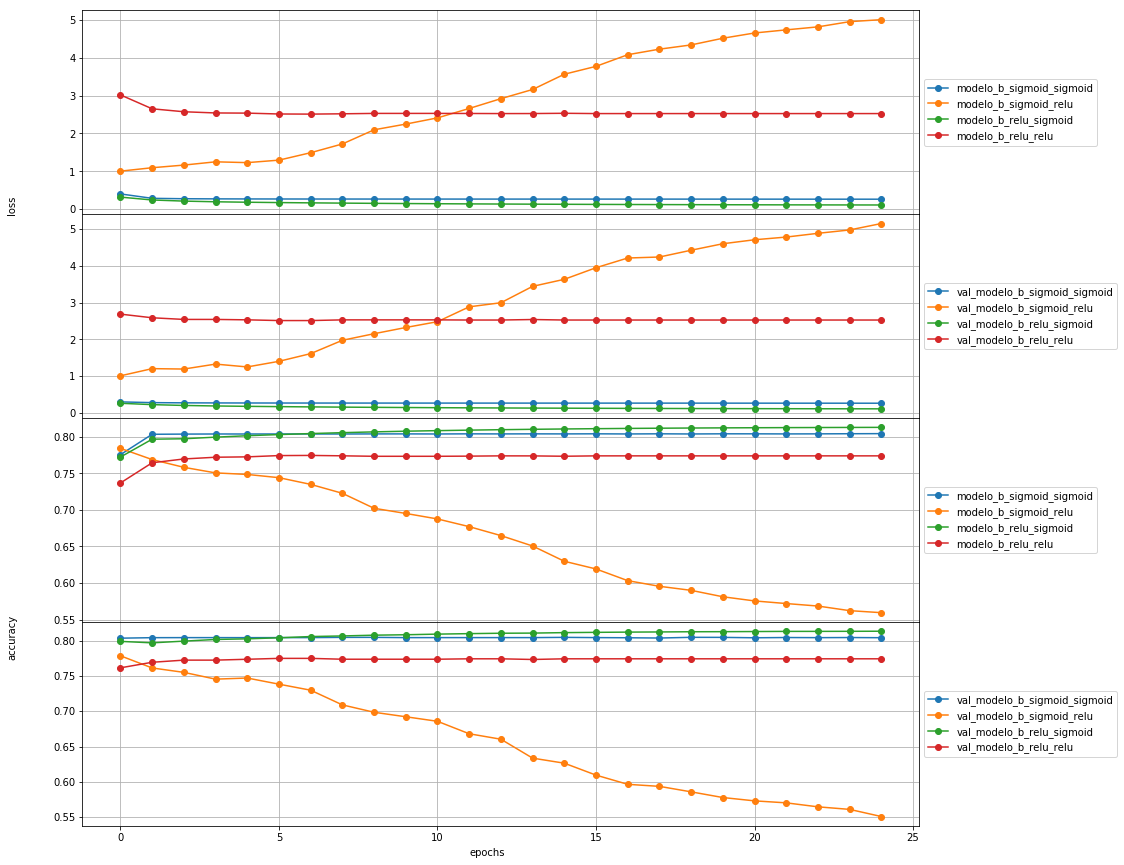

In [7]:
plot_data(modelos,4)

In [11]:
# Se experimenta con el cambio de dimension, con distintas configuraciones
# con la capa de activacion del decoder como sigmoid, dado que relu presenta resultados 
# no atrayentes.

modelos_d = defaultdict(list)
for dimension in [8,16,32,64,128]:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2+'_'+str(dimension)
            model, e, d = create_model(activation1,activation2,'b',dimension)
            #save model
            model.save_weights(os.path.join(os.getcwd(), 'exp', 'a2','model_weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp', 'a2', 'model_architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            #
            start = time.time()
            history =model.fit(X_train, X_train,
                                           epochs=25,
                                           batch_size=128,
                                           shuffle=True,
                                           validation_data=(X_val,X_val),verbose=0)
            modelos_d[name].append(history)
            modelos_d[name].append(d)
            modelos_d[name].append(e)
            modelos_d[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos_d[name].append(score)

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


10000/10000 [==============================] - 1s 74us/step


#### Sección b) Se comparan visialmente la reconstrucción que logra realizar el autoencoder. Determinar si la percepción visual se corresponde con el error de reconstrucción que se observa.

In [132]:
def plot_im(model,name,X):
    print(name)
    with open(os.path.join(os.getcwd(), 'exp', 'a', 'model_architecture_'+name+'.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))

    encoded_test = model[name][2].predict(X)
    decoded_test = model[name][1].predict(encoded_test)
    
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

modelo_b_sigmoid_sigmoid


<IPython.core.display.Javascript object>


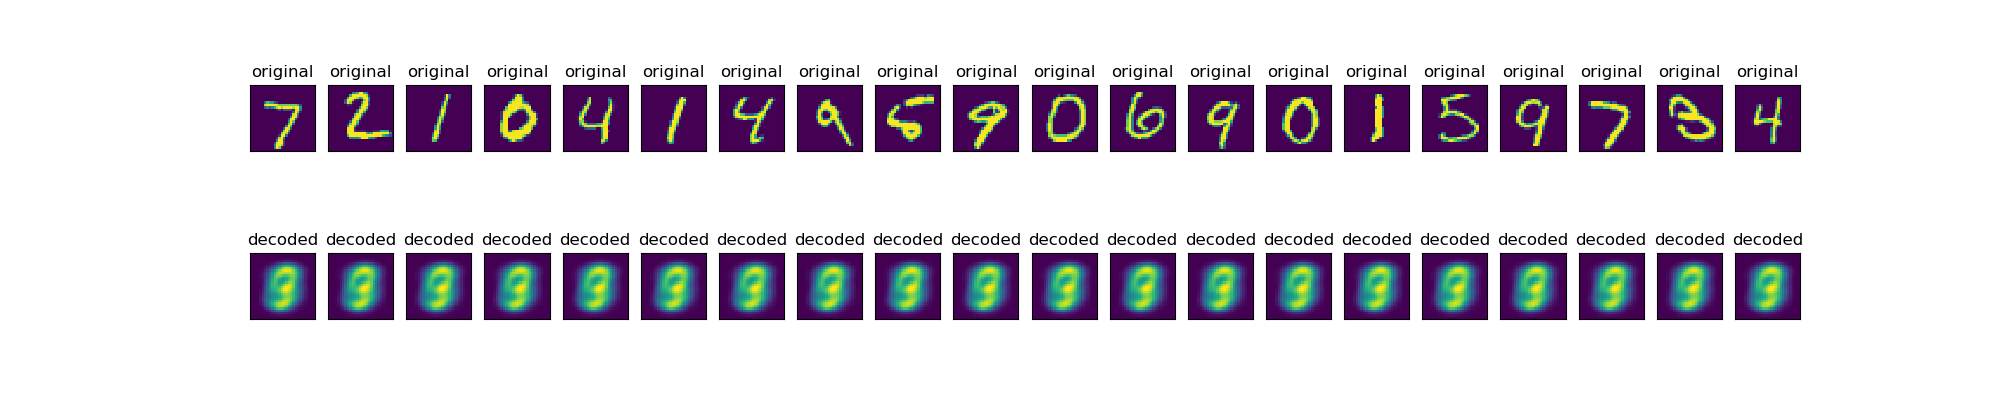

modelo_b_sigmoid_relu


<IPython.core.display.Javascript object>


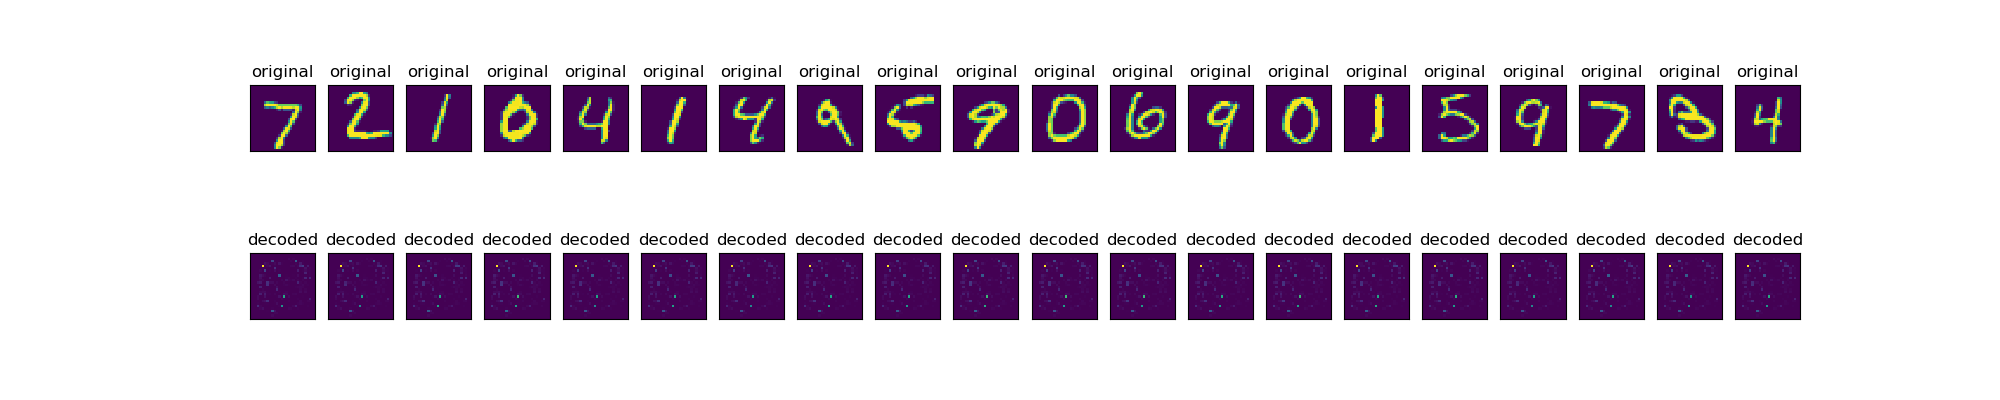

modelo_b_relu_sigmoid


<IPython.core.display.Javascript object>


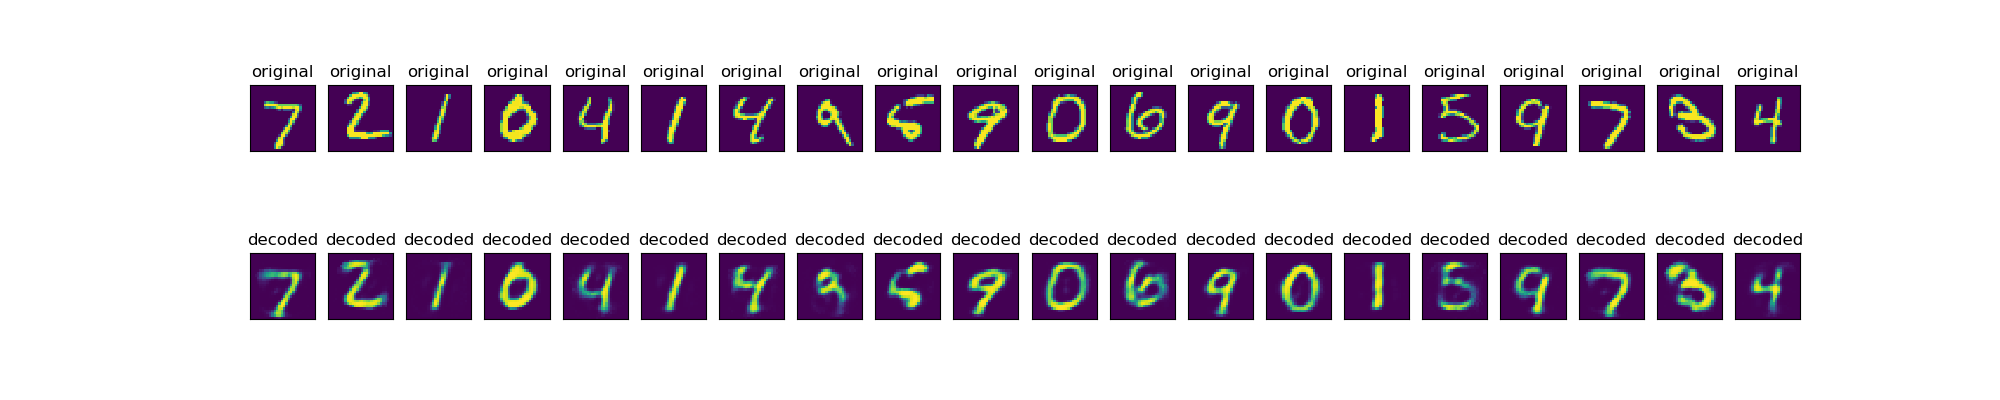

modelo_b_relu_relu


<IPython.core.display.Javascript object>


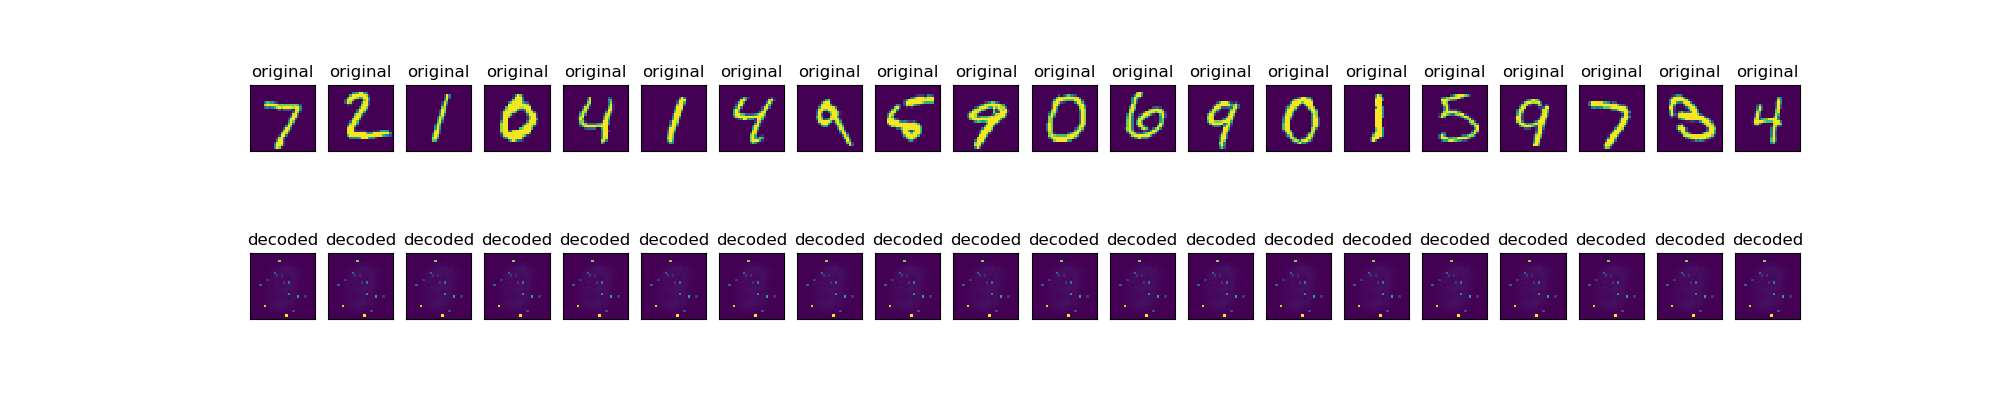

In [133]:
## verificar que encoder y decoder sean los mejores del punto anterior.
## mostra graficamente para las cuatro configuraciones del punto anterior
## seria interesante ver la imagen pequeña
from keras.models import load_model, model_from_json
#load other stuff ...
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            plot_im(modelos,name,X_test)

#### Sección c) Se verifica la calidad de la representación obtenida, para ello se construye un clasificador kNN.

In [100]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
def calidad(model,name):
    print(name)
    with open(os.path.join(os.getcwd(), 'exp','a','model_architecture_'+str(name)+'.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(os.path.join(os.getcwd(), 'exp','a','model_weights_'+str(name)+'.h5'))
    pca = PCA(n_components=10)
    #PCA
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test = pca.transform(X_test)
    #AUTOENCODER
    encoded_train = model[name][2].predict(X_train)
    encoded_test = model[name][2].predict(X_test)
    #CLASIFICATION
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, Y_train)
    print ('Classification Accuracy PCA %.2f' % clf.score(pca_test,Y_test))
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print ('Classification Accuracy %.2f' % clf.score(encoded_test,Y_test))

In [102]:
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            calidad(modelos,name)

modelo_b_sigmoid_sigmoid
Classification Accuracy PCA 0.91
Classification Accuracy 0.53
modelo_b_sigmoid_relu
Classification Accuracy PCA 0.91
Classification Accuracy 0.69
modelo_b_relu_sigmoid
Classification Accuracy PCA 0.91
Classification Accuracy 0.95
modelo_b_relu_relu
Classification Accuracy PCA 0.91
Classification Accuracy 0.00


Falta colocar la conclusión de que AE es peor de KNN (sería interesante poder justificar porque?)

** Quedo que el modelo relu-sigmoid obtiene mejor accuracy con respecto a PCA.

#### Sección d) Deep encoding, se experimenta el uso de más de dos capas ocultas para demostrar que mejora la compresión obtenida por PCA, utilizando el mismo número de dimensiones. Para ello se prueba con $d \in [2,4,8,16]$ y distintas profundidades $L \in [2,3,4]$ y se compara el desempeño tanto en el error de reconstrucción como en clasificación via kNN de cada representación

In [94]:
def get_numeros(numero,dimension):
    if(numero == 2):
        return [dimension, 1000]
    if(numero == 3):
        return [dimension, 500, 1000]
    if(numero == 4):
        return [dimension, 250, 500, 1000]
# Ejemplo de input ['sigmoid','relu'],['sigmoid','sigmoid'],[1000,250],2
def create_deep_model(activation_e, activation_d, dimlist, depth=2):
    input_img = Input(shape=(784,))
    encoded = Dense(dimlist[::-1][0], activation=activation_e[0])(input_img)
    #print('e',dimlist[::-1][0],activation_e[0])
    for i in range(1,depth):
        #print('e',dimlist[::-1][i],activation_e[i])  
        encoded = Dense(dimlist[::-1][i], activation=activation_e[i])(encoded)
    decoded = Dense(dimlist[1:][0], activation=activation_d[0])(encoded)
    #print('d',dimlist[1:][0],activation_d[0])
    for i in range(1,depth):
        if(i+1 == depth):
            #print('d',784,activation_d[::-1][:depth][::-1][i])
            decoded = Dense(784, activation=activation_d[::-1][:depth][::-1][i])(decoded)
        else:
            #print('d',dimlist[1:][i],activation_d[::-1][:depth][::-1][i])
            decoded = Dense(dimlist[i], activation=activation_d[i])(decoded)
    autoencoder = Model(input= input_img, output= decoded)
    encoder = Model(input= input_img, output= encoded)
    encoded_input = Input(shape=(dimlist[0],))
    decoder_layer = autoencoder.layers[-depth](encoded_input)        
    for i in range(1,depth):
        decoder_layer = autoencoder.layers[(-depth)+i](decoder_layer)
    decorder = Model(input= encoded_input,
                     output= decoder_layer)
    autoencoder.compile(optimizer=SGD(lr=1.0),
                        loss='binary_crossentropy',
                        metrics=[binary_accuracy])
    return autoencoder, encoder, decorder

In [95]:
modelos_profundos = defaultdict(list)
#activations
#activations = ? 17 combinaciones
encoder_activation = ['relu', 'relu', 'relu', 'relu']
decoder_activation = ['relu', 'relu', 'relu', 'sigmoid']
# dimension es el target
for dimension in [2, 4, 8, 16]:
    for layer in [2,3,4]:
            layers = get_numeros(layer,dimension)
            name = 'modelo_'+str(layer)+'-layer_'+str(dimension)+'-targetdim'
            print(name)
            model, e, d =create_deep_model(encoder_activation, 
                                            decoder_activation,
                                            layers, 
                                            layer)
            model.save_weights(os.path.join(os.getcwd(), 'exp','d','weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp','d','architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            start = time.time()
            history = model.fit(X_train, X_train,
                               epochs = 25,
                               batch_size= 128,
                               shuffle= True,
                               validation_data = (X_val, X_val), verbose = 0)
            modelos_profundos[name].append(history)
            modelos_profundos[name].append(d)
            modelos_profundos[name].append(e)
            modelos_profundos[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos_profundos[name].append(score)   

modelo_2-layer_2-targetdim


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


10000/10000 [==============================] - 1s 64us/step
modelo_3-layer_2-targetdim
10000/10000 [==============================] - 1s 57us/step
modelo_4-layer_2-targetdim
10000/10000 [==============================] - 1s 66us/step
modelo_2-layer_4-targetdim
10000/10000 [==============================] - 1s 61us/step
modelo_3-layer_4-targetdim
10000/10000 [==============================] - 1s 64us/step
modelo_4-layer_4-targetdim
10000/10000 [==============================] - 1s 64us/step
modelo_2-layer_8-targetdim
10000/10000 [==============================] - 1s 59us/step
modelo_3-layer_8-targetdim
10000/10000 [==============================] - 1s 64us/step
modelo_4-layer_8-targetdim
10000/10000 [==============================] - 1s 68us/step
modelo_2-layer_16-targetdim
10000/10000 [==============================] - 1s 63us/step
modelo_3-layer_16-targetdim
10000/10000 [==============================] - 1s 65us/step
modelo_4-layer_16-targetdim
10000/10000 [===========================

In [137]:
def plot_im(model,name,X):
    print(name)
    with open(os.path.join(os.getcwd(), 'exp', 'd', 'architecture_'+name+'.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(os.path.join(os.getcwd(), 'exp', 'd','weights_'+name+'.h5'))

    encoded_test = model[name][2].predict(X)
    decoded_test = model[name][1].predict(encoded_test)
    
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

modelo_2-layer_2-targetdim


<IPython.core.display.Javascript object>


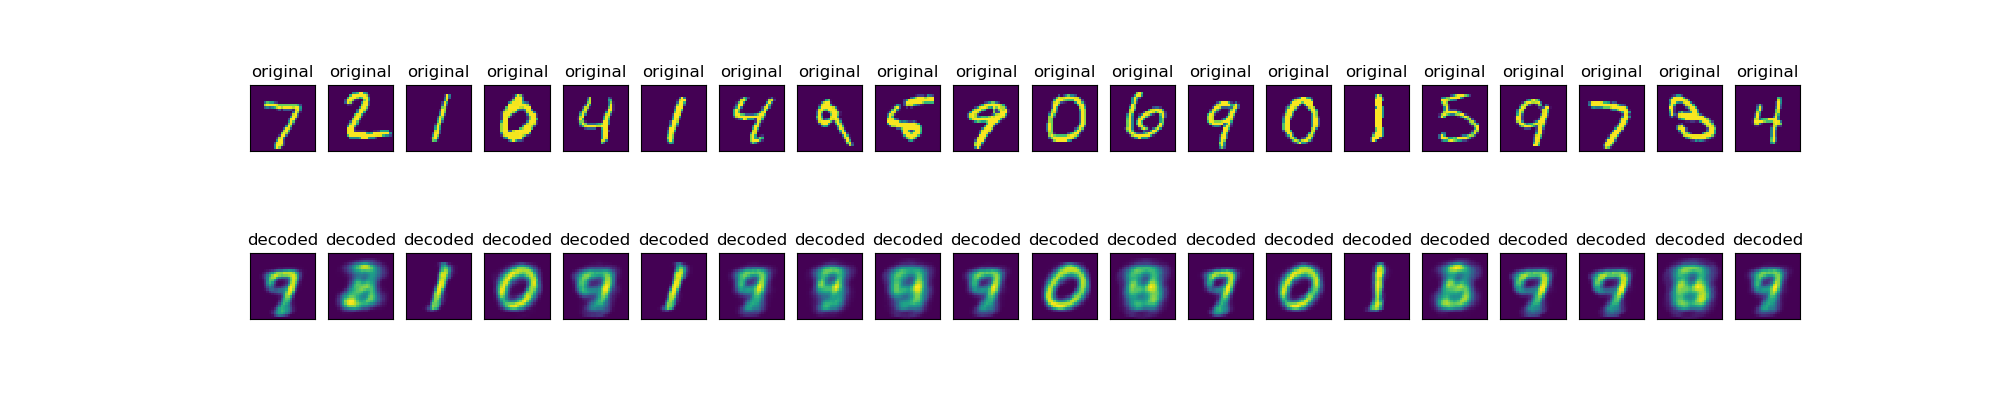

modelo_3-layer_2-targetdim


<IPython.core.display.Javascript object>


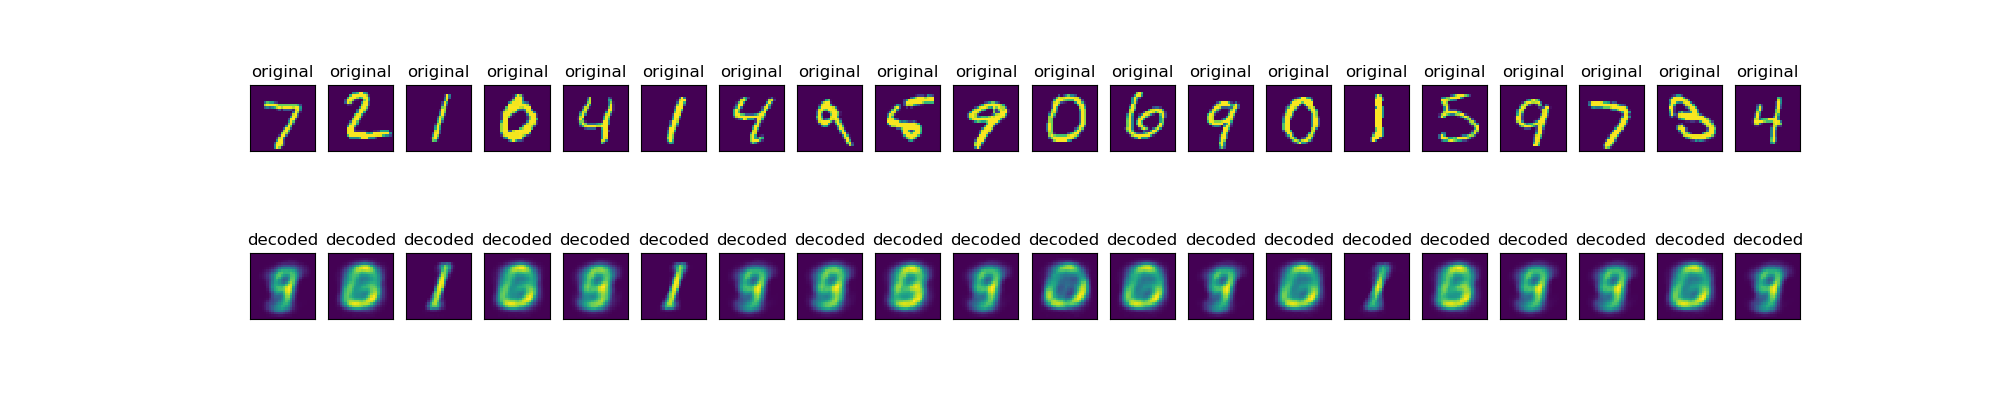

modelo_4-layer_2-targetdim


<IPython.core.display.Javascript object>


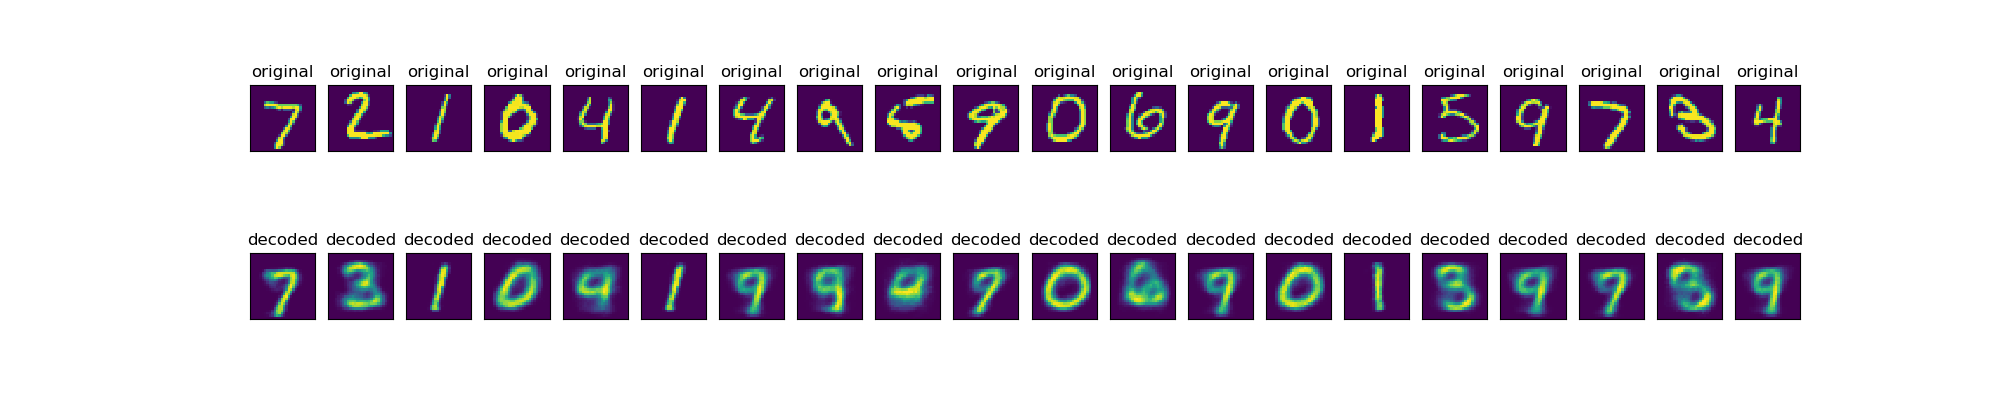

modelo_2-layer_4-targetdim


<IPython.core.display.Javascript object>


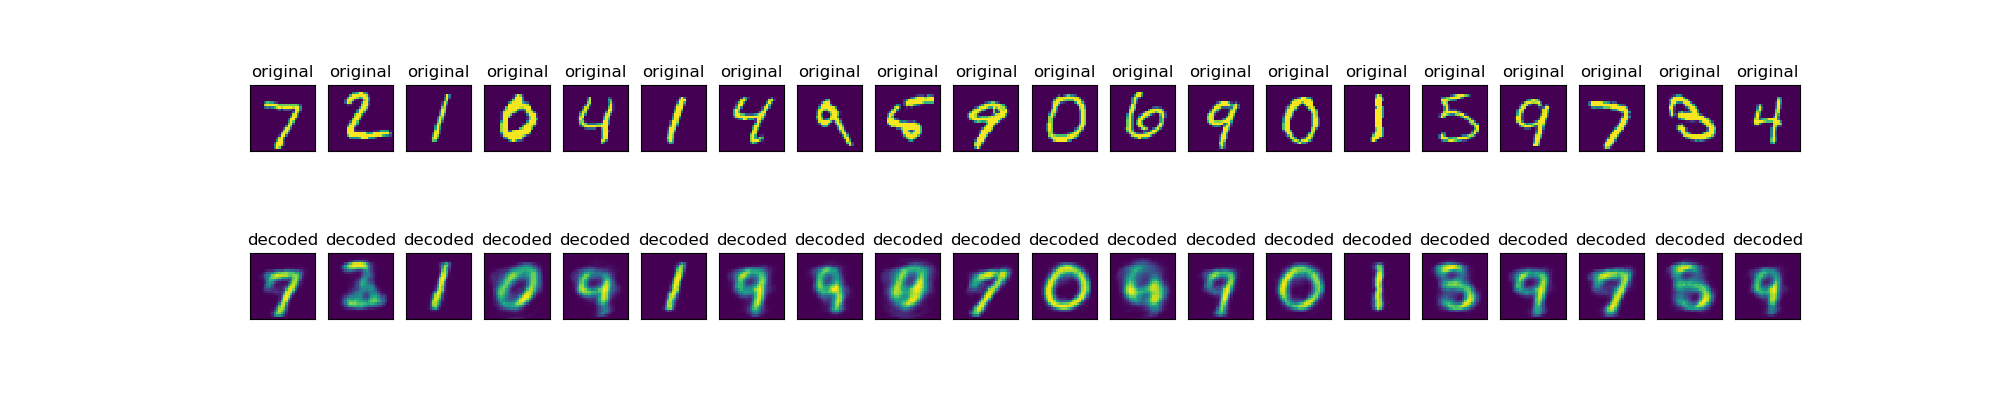

modelo_3-layer_4-targetdim


<IPython.core.display.Javascript object>


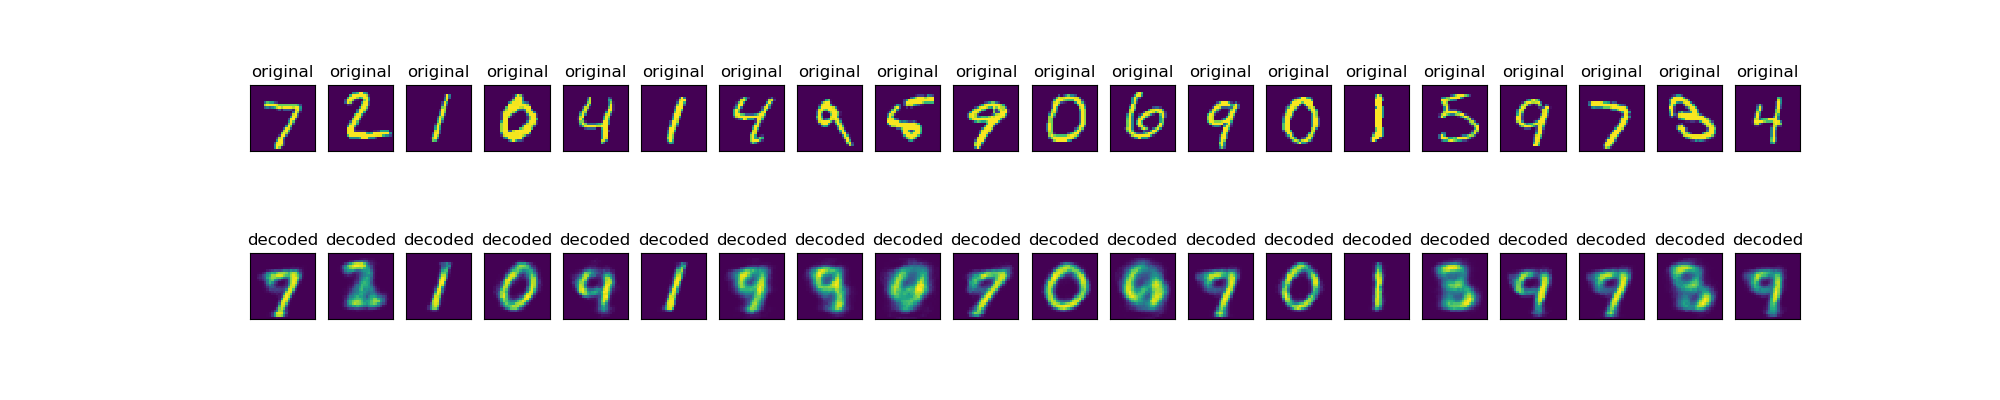

modelo_4-layer_4-targetdim


<IPython.core.display.Javascript object>


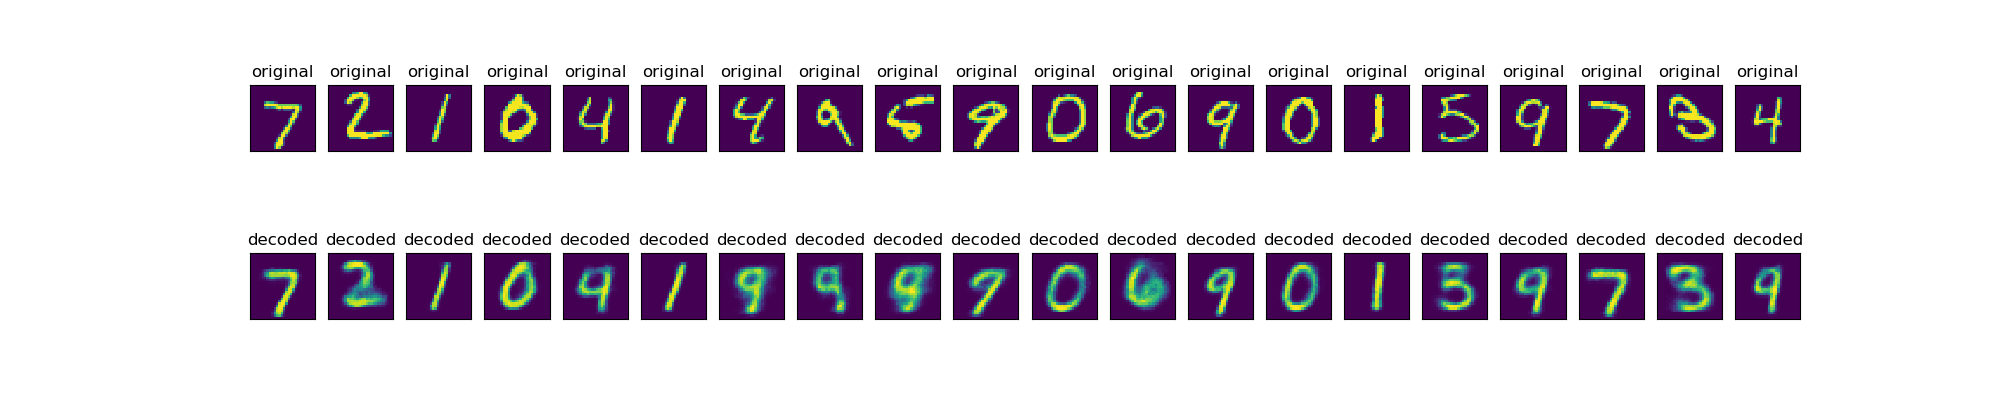

modelo_2-layer_8-targetdim


<IPython.core.display.Javascript object>


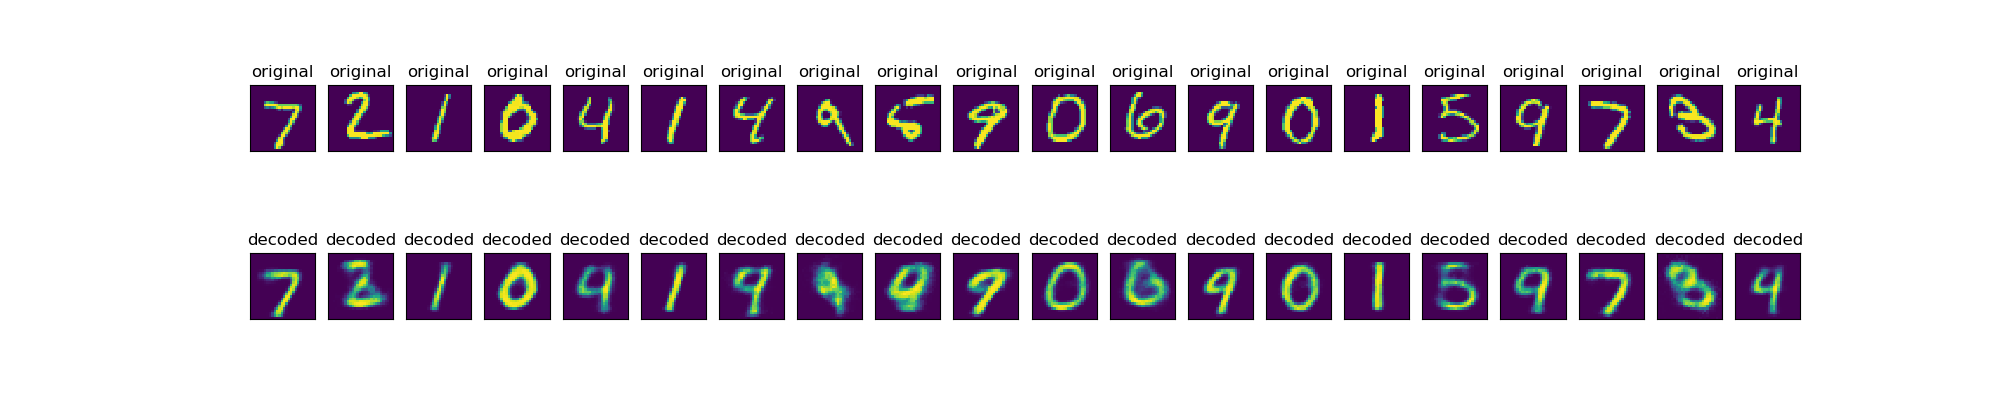

modelo_3-layer_8-targetdim


<IPython.core.display.Javascript object>


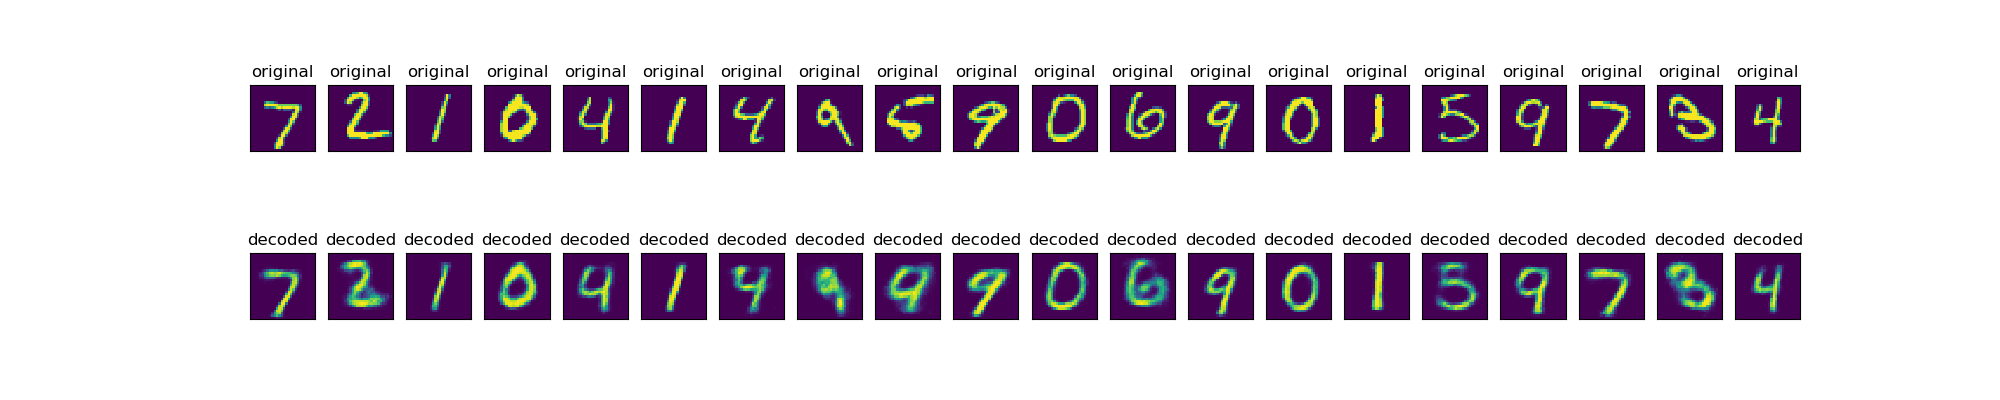

modelo_4-layer_8-targetdim


<IPython.core.display.Javascript object>


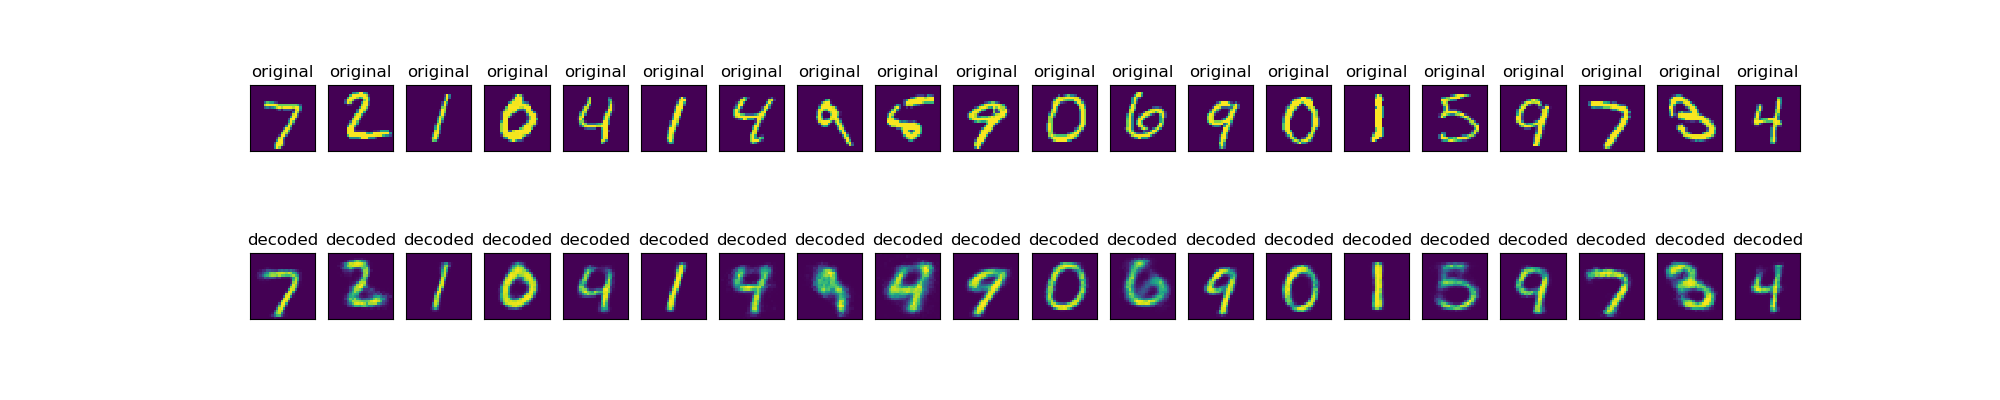

modelo_2-layer_16-targetdim


<IPython.core.display.Javascript object>


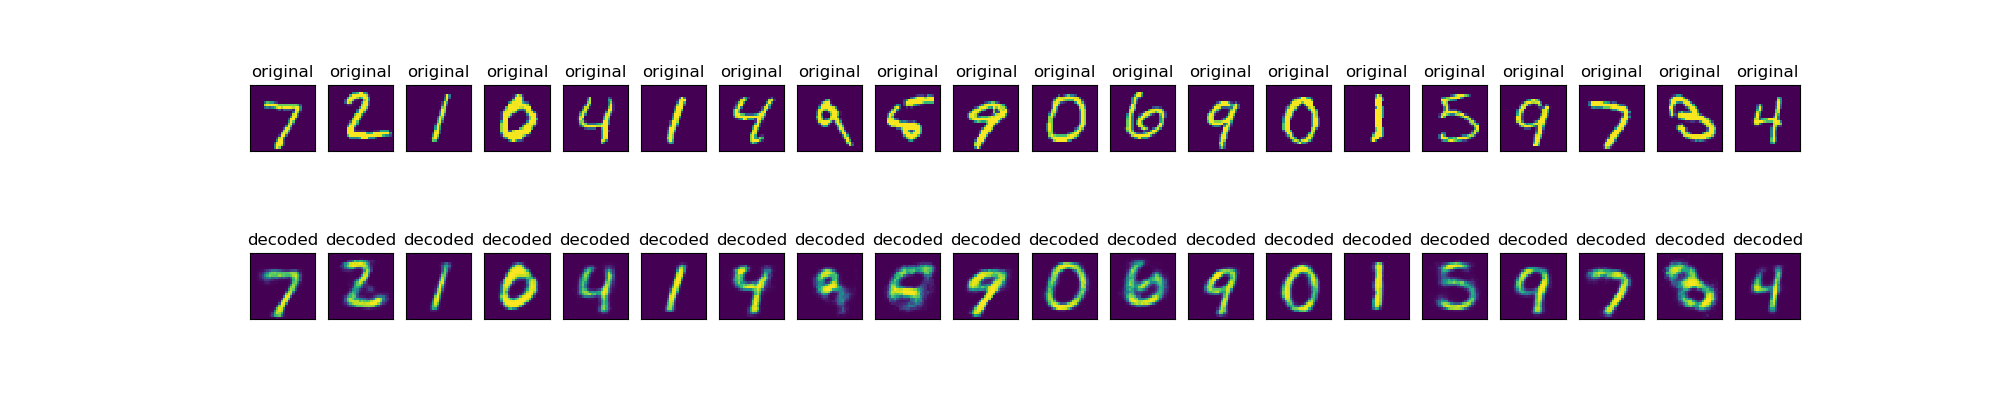

modelo_3-layer_16-targetdim


<IPython.core.display.Javascript object>


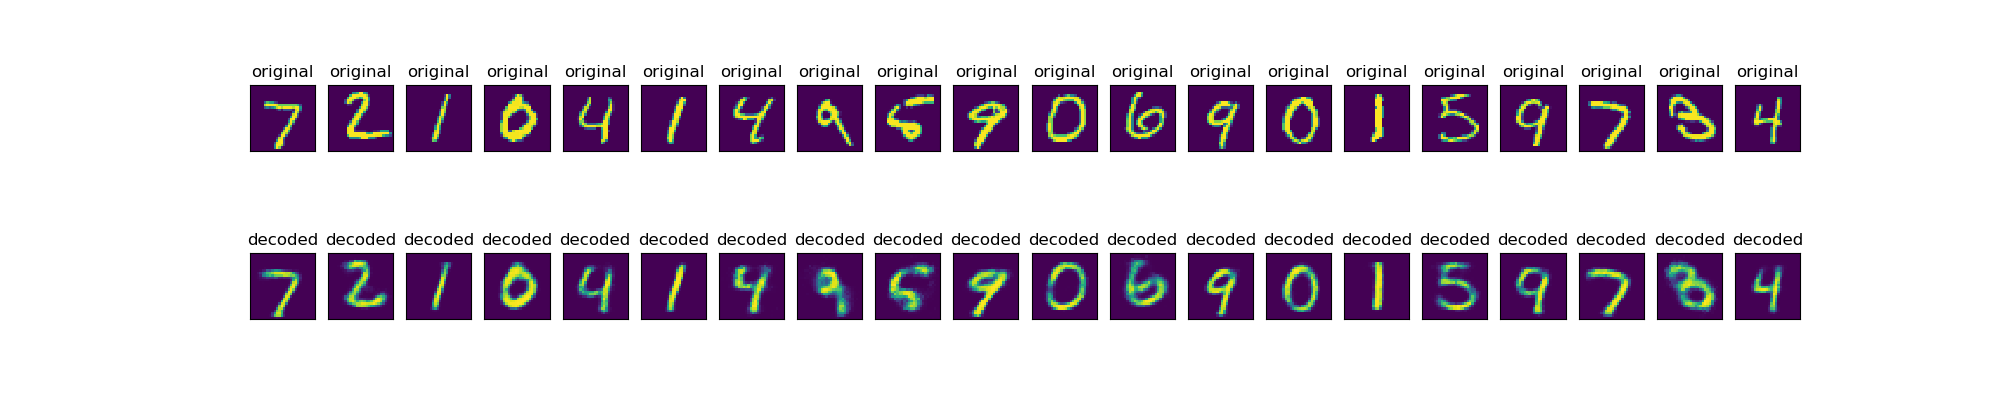

modelo_4-layer_16-targetdim


<IPython.core.display.Javascript object>


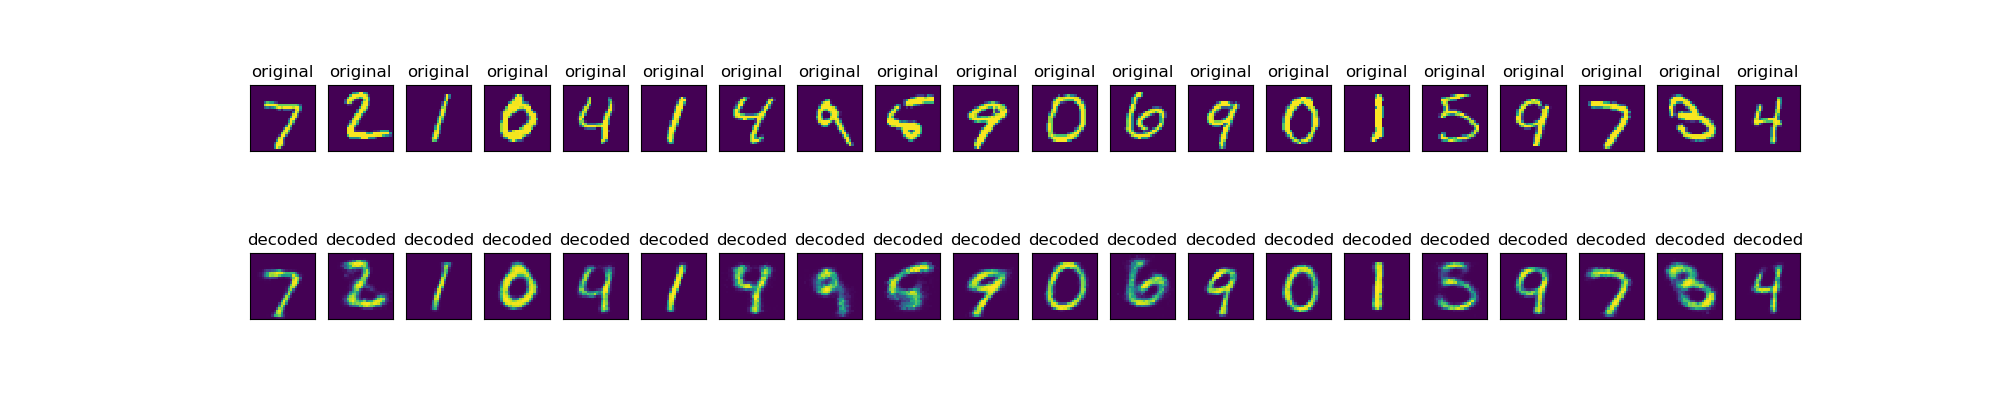

In [138]:
for dimension in [2, 4, 8, 16]:
    for layer in [2,3,4]:
            layers = get_numeros(layer,dimension)
            name = 'modelo_'+str(layer)+'-layer_'+str(dimension)+'-targetdim'
            plot_im(modelos_profundos,name,X_test)

<IPython.core.display.Javascript object>


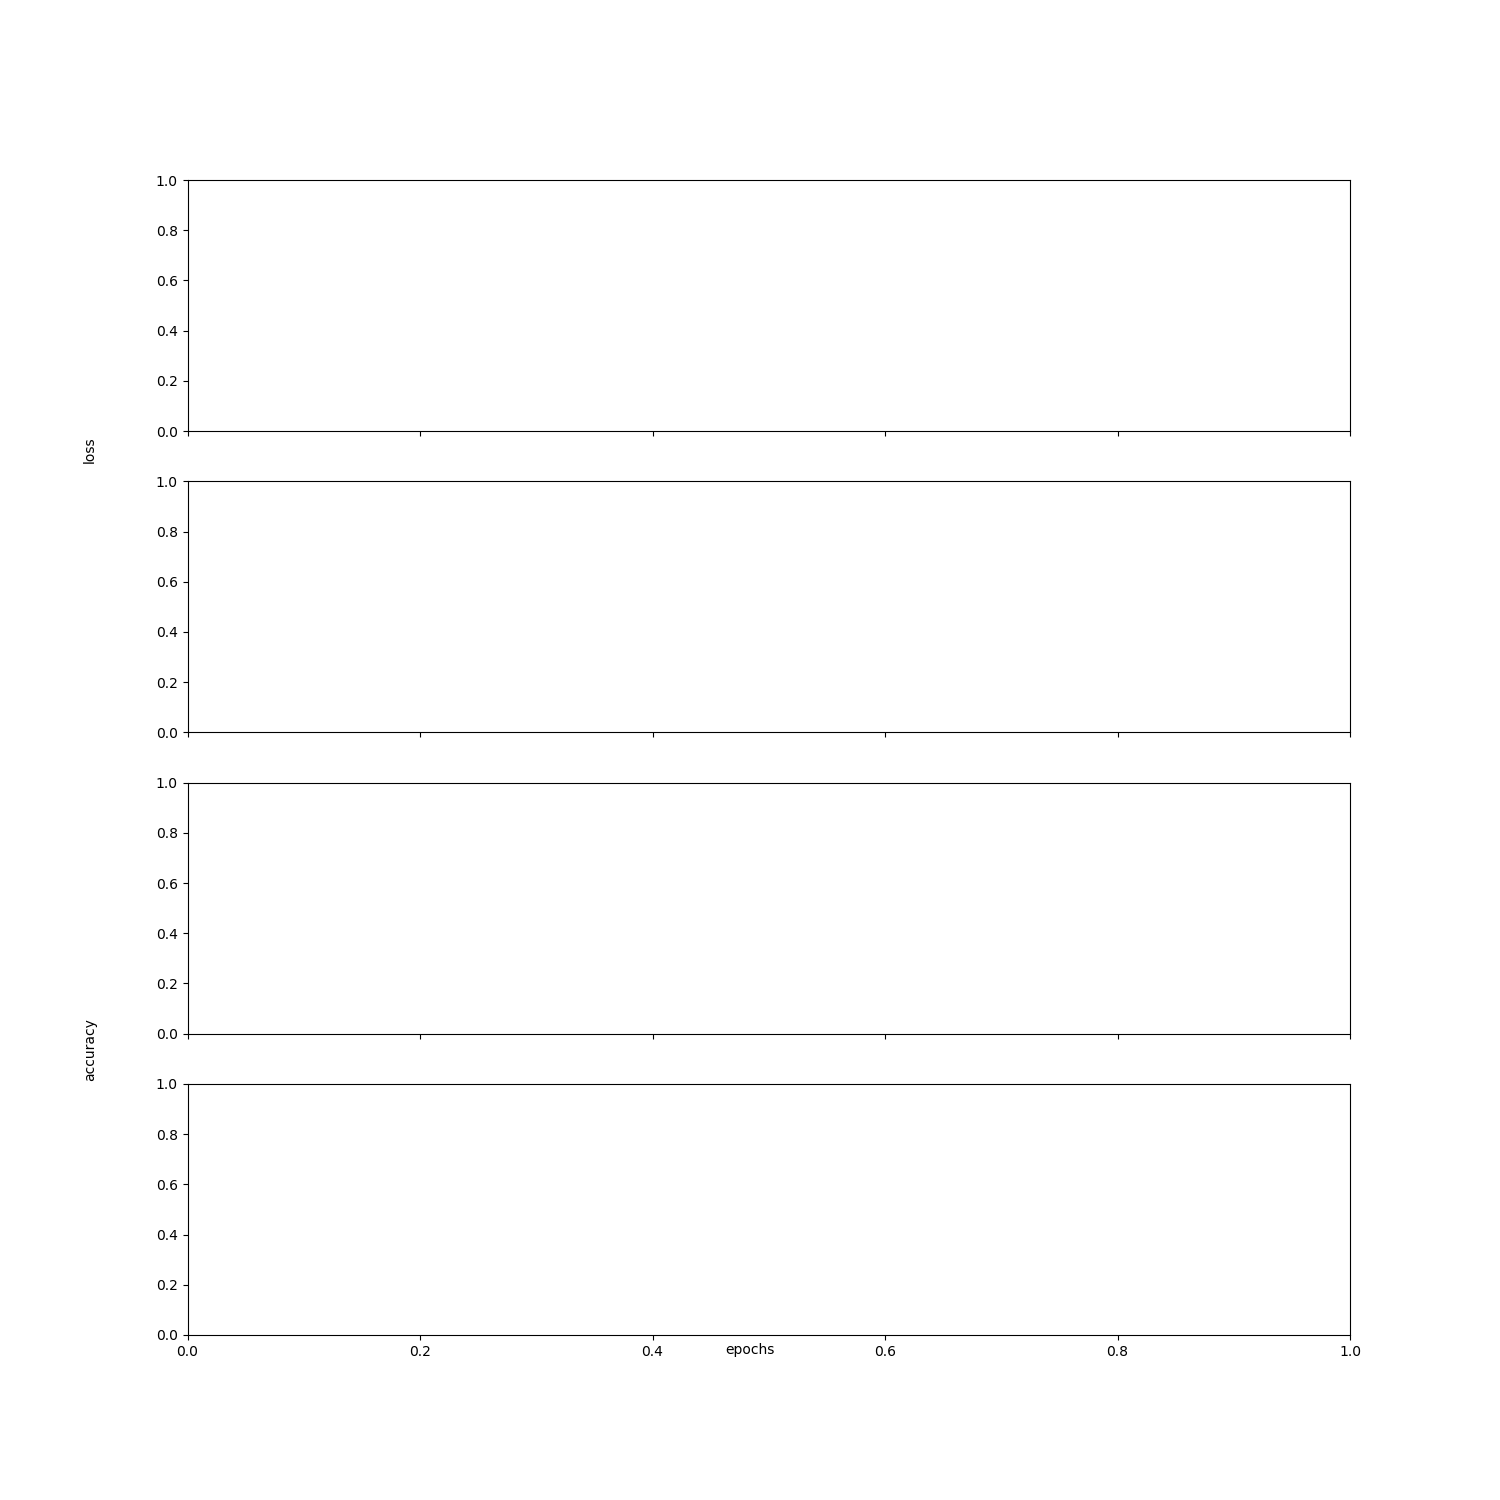

AttributeError: Unknown property cmap

In [131]:
plot_data(modelos_profundos,4)

#### Sección e) Se elije una de las representaciones anteriores y se visualizan usando la herramienta TSNE disponible en la librería sklearn. Para proceder con una comparación cualitativa de los resultados obtenidos mediante PCA y AE.

In [ ]:
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA


#### Sección f) Por ultimo se modifica el primer autoencoder (a) para trabajar directamente sobre las  imágenes de MNIST, sin tratarlas como vectores, sino como matrices de tamaño 1 x 28 x 28. Es posible utilizando capas convolucionales para definir el Encoder y el Decoder.

In [ ]:
X_train_ = x_train.astype('float32') / 255.
X_test_ = x_test.astype('float32') / 255.
X_train_ = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
X_test_ = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img_ = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()